# <center>Flow++ [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


**Variational Dequantization:**


**Logistic Mixture Coupling:**
\begin{equation*}
    \begin{cases}
        z_{1:d} = x_{1:d} \\
        z_{d+1:D} = \sigma^{-1}(\mathrm{MixLogCDF}(x_{d+1:D};\pi_\theta(x_{1:d}),\mu_\theta(x_{1:d}),s_\theta(x_{1:d})))\odot \exp(a_\theta(x_{1:d}))+b_\theta(x_{1:d})
    \end{cases}
\end{equation*}
where:
\begin{equation*}
    \mathrm{MixLogCDF}(x;\pi,\mu,s)=\sum_{k=1}^K \pi_i \sigma((x-\mu_i)\odot\exp(-s_i))
\end{equation*}
with $\pi$, $\mu$, $s$, $a$ and $b$ neural nets.

The coupling layer can be inverted by bisection (dichotomie?). For the determinant of the jacobian, we only need to compute probability densities of logistic mixtures:

TO do

In [3]:
class MLP(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        # self.layers.append(nn.Linear(nh,d_out))
        self.dense_a = nn.Linear(nh,d_out)
        self.dense_b = nn.Linear(nh,d_out)
        self.dense_pi = nn.Linear(nh,d_out)
        self.dense_mu = nn.Linear(nh,d_out)
        self.dense_s = nn.Linear(nh,d_out)


    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)

        a = self.dense_a(x)
        b = self.dense_b(x)
        pi = self.dense_pi(x)
        mu = self.dense_mu(x)
        s = self.dense_s(x)

        return a, b, pi, mu, s

In [4]:
## https://github.com/chrischute/flowplusplus/blob/master/models/flowplusplus/log_dist.py

def safe_log(x):
    return torch.log(x.clamp(min=1e-22))

def _log_pdf(x, mean, log_scale):
    """Element-wise log density of the logistic distribution."""
    z = (x - mean) * torch.exp(-log_scale)
    log_p = z - log_scale - 2 * F.softplus(z)

    return log_p


def _log_cdf(x, mean, log_scale):
    """Element-wise log CDF of the logistic distribution."""
    z = (x - mean) * torch.exp(-log_scale)
    log_p = F.logsigmoid(z)

    return log_p


def mixture_log_pdf(x, prior_logits, means, log_scales):
    """Log PDF of a mixture of logistic distributions."""
    log_ps = F.log_softmax(prior_logits, dim=1) \
        + _log_pdf(x.unsqueeze(1), means, log_scales)
    log_p = torch.logsumexp(log_ps, dim=1)

    return log_p


def mixture_log_cdf(x, prior_logits, means, log_scales):
    """Log CDF of a mixture of logistic distributions."""
    log_ps = F.log_softmax(prior_logits, dim=1) \
        + _log_cdf(x.unsqueeze(1), means, log_scales)
    log_p = torch.logsumexp(log_ps, dim=1)

    return log_p


def mixture_inv_cdf(y, prior_logits, means, log_scales,
                    eps=1e-10, max_iters=100):
    """Inverse CDF of a mixture of logisitics. Iterative algorithm."""
    if y.min() <= 0 or y.max() >= 1:
        raise RuntimeError('Inverse logisitic CDF got y outside (0, 1)')

    def body(x_, lb_, ub_):
        cur_y = torch.exp(mixture_log_cdf(x_, prior_logits, means,
                                          log_scales))
        gt = (cur_y > y).type(y.dtype)
        lt = 1 - gt
        new_x_ = gt * (x_ + lb_) / 2. + lt * (x_ + ub_) / 2.
        new_lb = gt * lb_ + lt * x_
        new_ub = gt * x_ + lt * ub_
        return new_x_, new_lb, new_ub

    x = torch.zeros_like(y)
    max_scales = torch.sum(torch.exp(log_scales), dim=1, keepdim=True)
    lb, _ = (means - 20 * max_scales).min(dim=1)
    ub, _ = (means + 20 * max_scales).max(dim=1)
    diff = float('inf')

    i = 0
    while diff > eps and i < max_iters:
        new_x, lb, ub = body(x, lb, ub)
        diff = (new_x - x).abs().max()
        x = new_x
        i += 1

    return x


def inverse(x, reverse=False):
    """Inverse logistic function."""
    if reverse:
        z = torch.sigmoid(x)
        ldj = F.softplus(x) + F.softplus(-x)
    else:
        z = -safe_log(x.reciprocal() - 1.)
        ldj = -safe_log(x) - safe_log(1. - x)

    return z, ldj

In [19]:
class LogisticMixture(BaseNormalizingFlow):
    """
        https://github.com/chrischute/flowplusplus/blob/master/models/flowplusplus/coupling.py
    """
    def __init__(self, NN,k):
        super().__init__()
        self.nn = NN
        self.k = k
        
    def forward(self,x):
        x1, x2 = x[:,:self.k],x[:,self.k:]
        a, b, pi, mu, s = self.nn(x1)
        
        z2 = mixture_log_cdf(x2, pi, mu, s).exp() ## MixLogCDF
#         z2 = torch.logit(z2, eps=1e-5) ## logit
        z2, log_J_logit = inverse(z2)
        z2 = z2*torch.exp(a)+b
        
        log_det = a+mixture_log_pdf(z2,pi,mu,s)+log_J_logit ##MixLogPDF+J_logit
        log_det = log_det.flatten(1).sum(-1)

        z = torch.cat([x1,z2], dim=1)
        return z, log_det
    
    def backward(self,z):
        z1, z2 = z[:,:self.k], z[:,self.k:]
        a, b, pi, mu, s = self.nn(z1)
        
        x2 = torch.exp(-a)*(z2-b)
        x2, log_J_sig = inverse(x2,reverse=True)
        x2 = x2.clamp(1e-5, 1. - 1e-5)
        x2 = mixture_inv_cdf(x2,pi,mu,s) ## inv MixLogCDF
        
        log_det = -a+log_J_sig-mixture_log_pdf(x2,pi,mu,s)##
        log_det = log_det.flatten(1).sum(-1)

        x = torch.cat([z1,x2], dim=1)
        return x, log_det

## Moons

In [24]:
def train_moons(model, n_epochs=10001):
    d = 2
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    train_loss = []

    for i in range(n_epochs):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det)
        
        if torch.any(torch.isnan(log_det)):
            print("???")

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())

        if i%100==0:
            print(i,train_loss[-1])

        if (i + 1) % 500 == 0:
            model.eval()

            xline = torch.linspace(-1.5, 2.5)
            yline = torch.linspace(-.75, 1.25)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                xy, log_s = model(xyinput.to(device))
                zz = (log_likelihood(xy[-1],log_s)).exp().cpu()
                zgrid = zz.reshape(100,100)

                z = base_distr.sample((100,))
                xs, _ = model.backward(z)
                x = xs[-1].detach()

                if torch.any(torch.isnan(zz)):
                    print("?")

                x = x.cpu().numpy()
                z = z.cpu().numpy()

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.colorbar()
            plt.scatter(x[:,0],x[:,1],c="red")
            plt.scatter(z[:,0],z[:,1],c="green")
            plt.xlim(-1.5,2.5)
            plt.ylim(-0.75,1.25)
            plt.title('iteration {}'.format(i + 1))
            plt.show()
            
    return train_loss

In [25]:
def loss(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [26]:
d = 2

n_layers = 5
# nets = [NN(d//2,10,10,32,0.2) for i in range(n_layers)]
nets = [MLP(d//2,32,d//2,3) for i in range(n_layers)]

flows = []
for i in range(n_layers):
    flows.append(LogisticMixture(nets[i],d//2))
    flows.append(Reverse(d))
    
model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  16985


0 5417.97021484375
100 308.69635009765625
200 92.42935180664062
300 -33.93751525878906
400 -113.5967025756836


/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


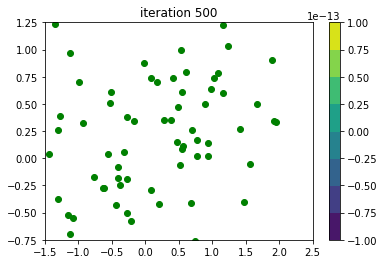

500 -147.63418579101562
600 -167.18240356445312
700 -180.10064697265625
800 -189.32476806640625
900 -196.36480712890625


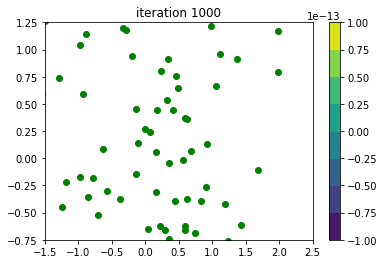

1000 -201.84970092773438
1100 -206.1728057861328
1200 -209.69290161132812
1300 -212.66761779785156
1400 -215.23651123046875


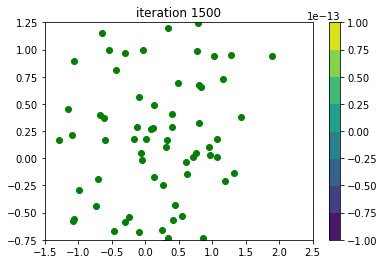

1500 -217.42173767089844
1600 -219.38595581054688
1700 -221.16001892089844
1800 -222.775634765625
1900 -224.242431640625


KeyboardInterrupt: ignored

In [27]:
train_loss = train_moons(model)

In [ ]:
plt.plot(train_loss)
plt.show()

## MNIST

In [ ]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [ ]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [ ]:
def loss(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

In [ ]:
def log_likelihood(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [ ]:
def val():
    d = 28*28
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    model.eval()
    zs,log_det = model.backward(z_random.reshape(-1,28*28))
    gen_imgs = zs[-1].view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [ ]:
d = 784

## Add batch normalization?
shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(ActNorm(dim=d))
    flows.append(LUInvertible(dim=d))
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    
model = NormalizingFlows(flows).to(device)

In [ ]:
d = 784

n_layers = 2
nets = [NN(d//2,96,10,32,0.2) for i in range(n_layers)]

flows = []
for i in range(n_layers):
    flows.append(ActNorm(dim=d))
    flows.append(LogisticMixture(nets[i],d//2))
    flow.append(Reverse(d))
    
model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

In [ ]:
num_epochs = 101

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()

    train_batch = []

    for n_batch, (data,_) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1,28*28)
        z, log_det = model(data)

        l = loss(z[-1], log_det)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_batch.append(l.item())


    print(epoch, np.mean(train_batch))
    train_losses.append(np.mean(train_batch))

    if epoch % 50 == 0:
        val()


In [ ]:
test_batch = []

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det)

    test_batch.append(l.mean().item())


In [ ]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = log_likelihood / (np.prod(784) * np.log(2.))
print(bpd)

In [ ]:
d = 28*28
torch.manual_seed(42)
r,c = 5,5
z_random = torch.randn(r,c,d,device=device)
model.eval()
zs,log_det = model.backward(z_random.reshape(-1,28*28))
gen_imgs = zs[-1].view(-1,28,28)
gen_imgs = gen_imgs.detach().cpu()
lambd = 1e-6
gen_imgs = (torch.sigmoid(gen_imgs)-lambd)/(1-2*lambd)

cpt = 0
fig,ax = plt.subplots(r,c)
for i in range(r):
    for j in range(c):
        ax[i,j].imshow(gen_imgs[cpt],"gray")
        cpt += 1
plt.show()

## References

<a id="reference1"></a>

[1] Ho, J., Chen, X., Srinivas, A., Duan, Y., & Abbeel, P. Glow: Generative flow with invertible 1x1 convolutions. arXiv preprint arXiv:1902.00275. (2019). [link](https://arxiv.org/pdf/1902.00275)